## Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.layers import Dropout
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading and Preprocessing Data 

In [3]:
train_path = r"...\Train"
val_path = r"...\Validation"
test_path = r"...\Test"

datagen = ImageDataGenerator(brightness_range=[0.3,1.5],rescale=1.0/255.0)

train_it = datagen.flow_from_directory(train_path, batch_size=32,target_size=(256, 256), class_mode="binary")
val_it = datagen.flow_from_directory(val_path, batch_size=10, target_size=(256, 256), class_mode="binary")
test_it = datagen.flow_from_directory(test_path, batch_size=10, target_size=(256, 256), class_mode="binary")

Found 9998 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## Creating the Model

In [76]:
def create_model():

    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation = "relu",input_shape=(256,256,3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))
    
    model.summary()
    
    return model

In [77]:
model = create_model()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 60, 60, 32)      

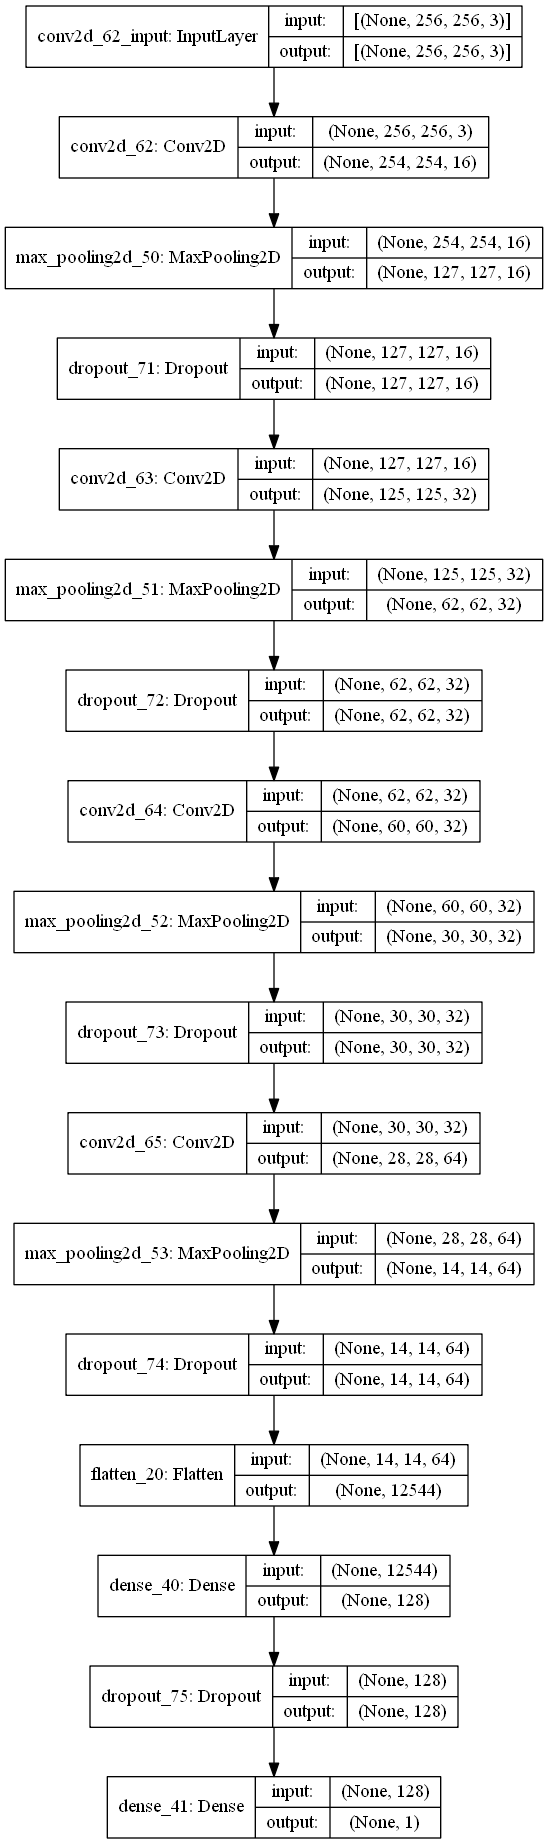

In [78]:
import graphviz
import pydot
plot_model(model, to_file='multilayer_perceptron_graph.png', show_shapes=True, show_layer_names=True)

In [79]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
print("Model Compiled!")

Model Compiled!


## Training the Model 

In [80]:
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

callbacks_list = [earlystop , checkpoint]

training_history = model.fit(train_it, epochs= 10, steps_per_epoch=312, validation_data=val_it, callbacks=callbacks_list)
print("Model Trained!")

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/10
312/312 [==============================] - 23s 72ms/step - loss: 0.3430 - accuracy: 0.8489 - val_loss: 0.1230 - val_accuracy: 0.9700

Epoch 00001: val_accuracy improved from -inf to 0.97000, saving model to weights_best.hdf5
Epoch 2/10
312/312 [==============================] - 22s 71ms/step - loss: 0.1208 - accuracy: 0.9590 - val_loss: 0.1038 - val_accuracy: 0.9663

Epoch 00002: val_accuracy did not improve from 0.97000
Epoch 3/10
312/312 [==============================] - 22s 71ms/step - loss: 0.0828 - accuracy: 0.9734 - val_loss: 0.0468 - val_accuracy: 0.9825

Epoch 00003: val_accuracy improved from 0.97000 to 0.98250, saving model to weights_best.hdf5
Epoch 4/10
312/312 [==============================] - 22s 71ms/step - loss: 0.0669 - accuracy: 0.9776 - val_loss: 0.0705 - val_accuracy: 0.9800

Epoch 00004: val_accuracy did not improve from 0.98250
Epoch 5/10
312/312 [==============================] - 22s 71ms/step - loss: 0.0664 - accuracy: 0.9786 - val_loss: 0.0298 - va

In [9]:
#filepath="weights_best.hdf5"
#model.load_weights(filepath)
#model = model.load_weights(filepath)

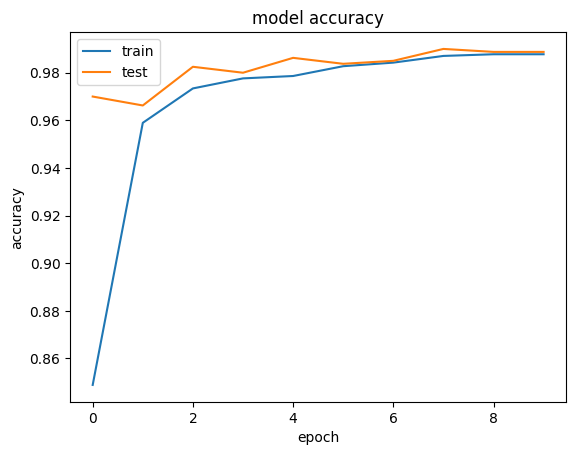

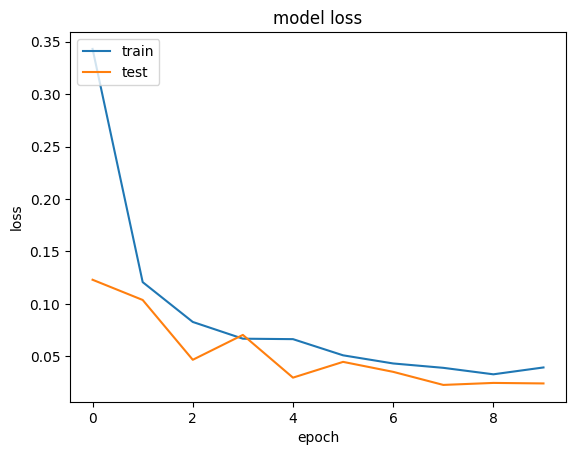

In [81]:
# summarize history for training and validation accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating the Model

In [82]:
scores = model.evaluate(test_it)
print("Model Evaluated with accuracy:", scores[1]*100, "%")

100/100 [==============================] - 2s 22ms/step - loss: 0.0412 - accuracy: 0.9829
Model Evaluated with accuracy: 98.28628897666931 %


## Detecting Face Locations

In [83]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detection_frame(img, x, y, w, h, prediction):
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
    output = []
    
    for (x,y,w,h) in faces:
        cropped_image = img[y:y+h, x:x+w]
        img_arr = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        img_arr = cv2.resize(img_arr, (256,256), interpolation = cv2.INTER_AREA)
        img_arr = np.expand_dims(img_arr, 0)
        prediction = model.predict(img_arr)
        output.append([x,y,w,h,prediction])
    return output

## Reading from Camera

In [85]:
x = -100
y = -100
w = 0 
h = 0
prediction = 0

# define a video capture object
vid = cv2.VideoCapture(0)
itera = 0  
while(True):
    
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    
    #iterate the detection function once every 5 frames
    itera += 1
    if itera % 5 == 0 or itera <=5 :
        
        #Function implementation
        output = face_detection_frame(frame, x, y, w, h, prediction)
        
    for (x,y,w,h,prediction) in output:
        #During the 5 frames we produce the same output of the last function implementation
        if prediction > 0.5 : #If without mask
            cv2.putText(img=frame, text='without mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

        else :                #If with mask
            cv2.putText(img=frame, text='with mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
        
# After the loop release the cap object  
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

## Reading from a Video File

In [ ]:
x = -100
y = -100
w = 0 
h = 0
prediction = 0

cap = cv2.VideoCapture("video.mp4")
itera = 0 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        
        itera += 1
        if itera % 5 == 0 or itera <=5 :

            #Function implementation
            output = face_detection_frame(frame, x, y, w, h, prediction)
        
        for (x,y,w,h,prediction) in output:
            #During the 5 frames we produce the same output of the last function implementation
            if prediction > 0.5 : #If without mask
                cv2.putText(img=frame, text='without mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

            else :                #If with mask
                cv2.putText(img=frame, text='with mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
 
        out.write(frame)
        # Display the resulting frame
        cv2.imshow('Frame',frame)
 
        # Press Q on keyboard to  exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
 
  # Break the loop
    else: 
        break
# When everything done, release the video capture object
cap.release()
out.release()
# Closes all the frames
cv2.destroyAllWindows()